### Import libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pandas import DataFrame
from keras import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose

### Utility functions 

In [ ]:

def split_train_validate_test(df: DataFrame, train_percent=.6, validate_percent=.2, test_percent=.2):
    """
    Splits the given DataFrame into training, validation, and testing datasets based on the specified percentages.

    Parameters:
    df (DataFrame): The input DataFrame to be split.
    train_percent (float): The percentage of data to be used for training. Default is 0.6 (60%).
    validate_percent (float): The percentage of data to be used for validation. Default is 0.2 (20%).
    test_percent (float): The percentage of data to be used for testing. Default is 0.2 (20%).

    Returns:
    tuple: A tuple containing three DataFrames - (train, validate, test).
    """
    df.sort_values(by="Date", inplace=True) 
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    
    return train, validate, test

def plot_history(history):
    """
    Plots the training and validation metrics (MAE and MSE) over epochs from the given training history.

    Parameters:
    history (keras.callbacks.History): The history object returned by the `fit` method of a Keras model.

    Description:
    - This function extracts the training and validation metrics (Mean Absolute Error and Mean Squared Error) 
      from the history object and visualizes them using line plots.
    - The first plot shows the Mean Absolute Error (MAE) for both training and validation over epochs.
    - The second plot shows the Mean Squared Error (MSE) for both training and validation over epochs.

    Returns:
    None
    """
    history_dict = history.history

    # MAE
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 1, 1)
    plt.plot(history_dict['mae'], label='Training MAE')
    plt.plot(history_dict['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)

    # MSE
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['mse'], label='Training MSE')
    plt.plot(history_dict['val_mse'], label='Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Training and Validation MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def load_data():
    df = pd.read_csv('./training_data/GBPUSD_open_5year.csv')
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
    df.sort_values(by="Date", inplace=True)
    return df


def plot_gbp_usd(data):
    """
    Plots the GBP/USD exchange rate for multiple datasets.

    Parameters:
    data (list): A list of datasets, where each dataset is a tuple containing:
                 - dates (array-like): The dates for the data points.
                 - prices (array-like): The corresponding GBP/USD prices.
                 - label (list): A list containing a single label for the dataset.

    Description:
    - Iterates through the datasets and plots the GBP/USD prices against their dates.
    - Uses distinct colors for each dataset and adds a legend for clarity.
    - Formats the x-axis with quarterly ticks and rotates them for better readability.

    Returns:
    None
    """
    plt.figure(figsize=(14, 7))
    plt.title('GBPUSD Exchange Rate')
    plt.ylabel('Price GBP-USD')

    colors = plt.cm.tab10.colors  # Use a colormap for distinct colors

    # Iterate through each dataset in the array
    for idx, dataset in enumerate(data):
        dates = dataset[0]
        prices = dataset[1]
        label = dataset[idx][2][0]
        plt.plot(dates, prices, label=f'{label}', color=colors[idx % len(colors)], alpha=0.7)

    plt.xticks(pd.date_range(start=min(dates), end=max(dates), freq='3MS'), rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

def pre_process_data(df: DataFrame):
    """
    Pre-processes the given DataFrame by decomposing the 'Open' column into trend, seasonality, and noise components.
    Additionally, it extracts temporal features such as week, month, and day.

    Parameters:
    df (DataFrame): The input DataFrame containing a 'Date' column and an 'Open' column.

    Returns:
    DataFrame: The modified DataFrame with added columns for trend, seasonality, noise, week, month, and day.
    """
    # Decompose the 'Open' column into trend, seasonality, and noise
    decomp = seasonal_decompose(df["Open"], model='additive', period=30)  # Adjust period based on seasonality
    df["Trend"] = decomp.trend.bfill().ffill()
    df["Seasonality"] = decomp.seasonal.bfill().ffill()
    df["Noise"] = decomp.resid.bfill().ffill()

    # Extract temporal features
    df["Week"] = df["Date"].dt.isocalendar().week
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day

    return df

def plot_pre_processed_data(df: DataFrame):
    """
    Plots the decomposed components (Trend, Seasonality, Noise) of the given DataFrame along with the original data.

    Parameters:
    df (DataFrame): The input DataFrame containing 'Date', 'Open', 'Trend', 'Seasonality', and 'Noise' columns.

    Description:
    - This function creates a multi-panel plot to visualize the original data and its decomposed components.
    - Each subplot corresponds to one of the components or the original data.

    Returns:
    None
    """
    # Plot the decomposed components
    plt.figure(figsize=(14, 10))

    # Plot the original data
    plt.subplot(4, 1, 1)
    plt.plot(df["Date"], df["Open"], label="Original", color="blue")
    plt.title("Original Data")
    plt.legend()

    # Plot the trend
    plt.subplot(4, 1, 2)
    plt.plot(df["Date"], df["Trend"], label="Trend", color="orange")
    plt.title("Trend")
    plt.legend()

    # Plot the seasonality
    plt.subplot(4, 1, 3)
    plt.plot(df["Date"], df["Seasonality"], label="Seasonality", color="green")
    plt.title("Seasonality")
    plt.legend()

    # Plot the noise
    plt.subplot(4, 1, 4)
    plt.plot(df["Date"], df["Noise"], label="Noise", color="red")
    plt.title("Noise")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_train_val_evaluation_history(t, v, type="MAE"):
    """
    Plots the training and validation evaluation history for a given metric type.

    Parameters:
    t (list): Training metric values over epochs.
    v (list): Validation metric values over epochs.
    type (str): The type of metric to plot. Default is "MAE". Options are "MAE" or "MSE".

    Description:
    - This function creates a line plot comparing the training and validation metric values over epochs.
    - The x-axis represents the epochs, and the y-axis represents the metric values.
    - The plot includes a legend to distinguish between training and validation metrics.

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    plt.plot(t, label=f'Training {type}', color='blue')
    plt.plot(v, label=f'Validation {type}', color='orange')
    plt.title(f"Training and Validation {type}")
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean {"Absolute" if type == "MAE" else "Squared"} Error ({type})')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_evaluation_metrics(y_true, y_pred):
    """
    Prints evaluation metrics for the given true and predicted values.

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    dict: A dictionary containing the calculated metrics (MAE, MSE, R^2, MAPE).
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true.values - y_pred.flatten()) / y_true.values)) * 100
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"R^2 Score: {r2:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
    return {"MAE": mae, "MSE": mse, "R Square": r2, "MAPE": mape}

def time_sequence_generator(feature, target, time_step):
    """
    Generates sequences of features and corresponding targets for time series data.

    Parameters:
    feature (array-like): The input features for the time series.
    target (array-like): The target values corresponding to the features.
    time_step (int): The number of time steps to include in each sequence.

    Returns:
    tuple: A tuple containing two numpy arrays:
           - X: The generated feature sequences of shape (n_samples, time_step, n_features).
           - y: The corresponding target values of shape (n_samples,).
    """
    X = []
    y = []
    # Iterate over data to create sequences
    for i in range(time_step, len(feature)):
        X.append(feature[i - time_step:i])  
        y.append(target[i])  
    
    return np.array(X), np.array(y)

# 1. Visualize the data

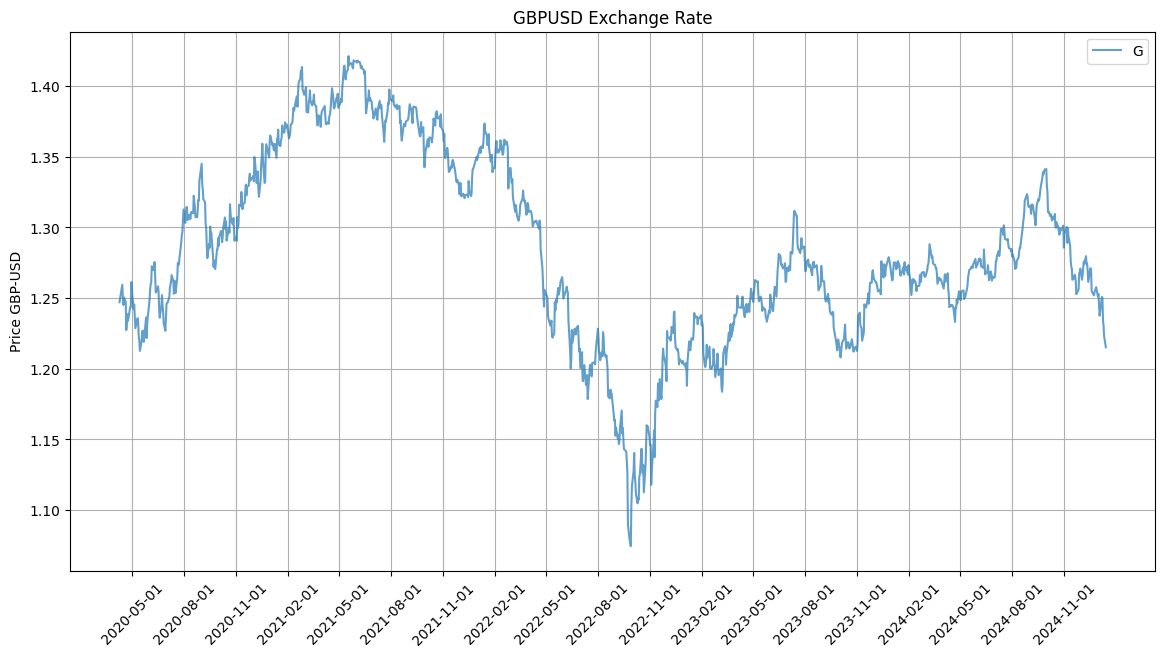

In [ ]:
data = load_data()
plot_gbp_usd([[data['Date'], data['Open'], "GBPUSD Open"]])

# 2. Pre-process the data
Dissect temporal information like Trend, Seasonality, Noise, Day, Week & Month   

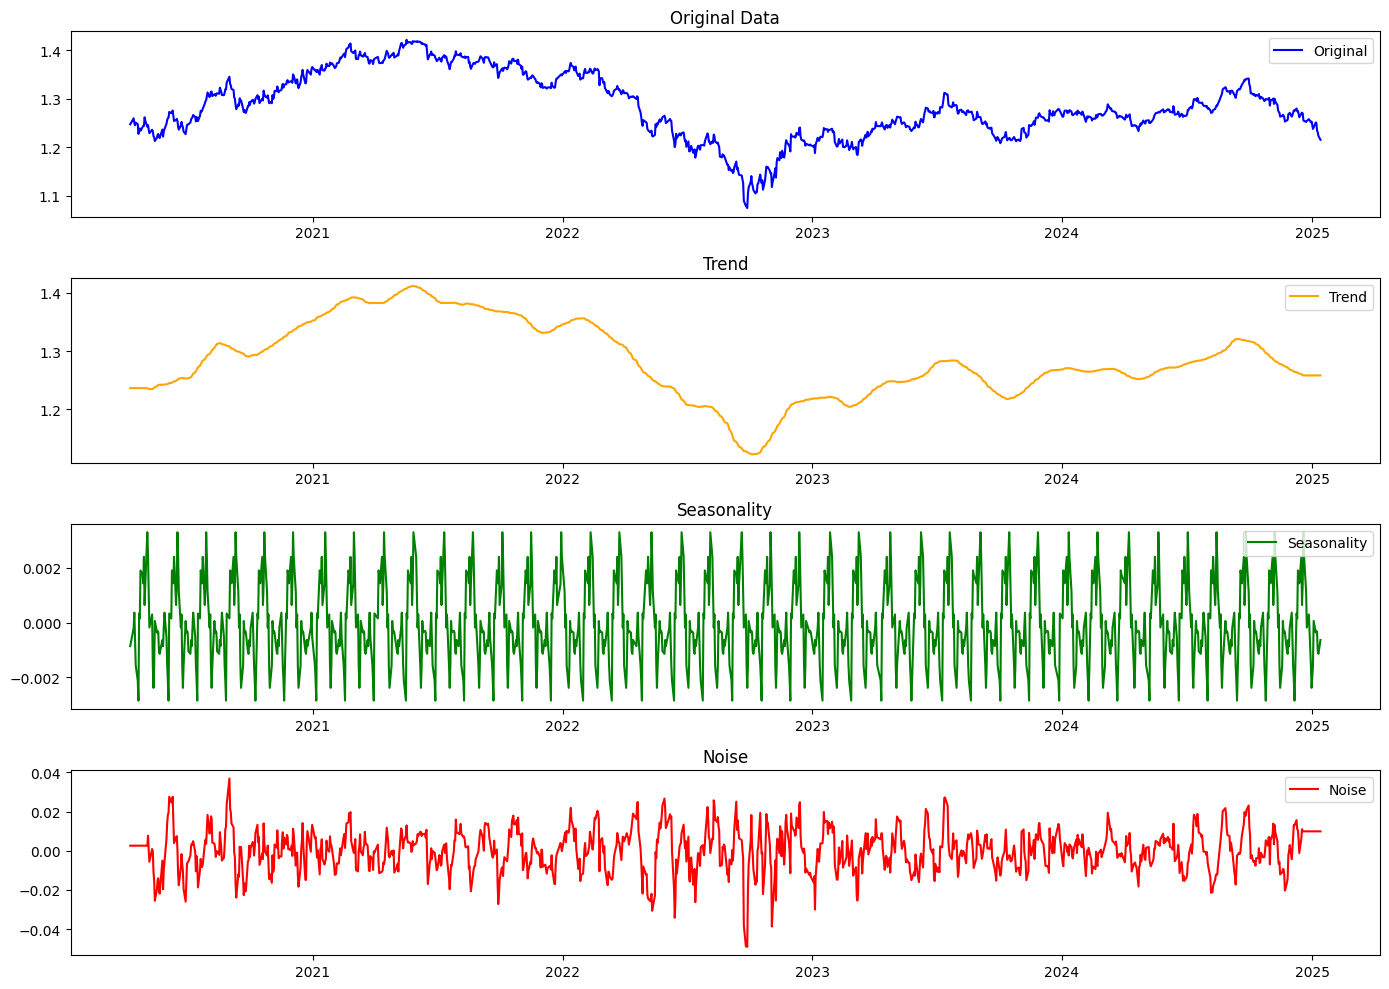

In [5]:
# General pre-process data for overall models
df = load_data()
df = pre_process_data(df)
plot_pre_processed_data(df)


# 3. Model based on each time instance

### 3.1 Split the Test, validate and Train data 


In [6]:
# Training  and Target Features
features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day']
target = "Open"

# Split data 
u_train, u_validate, u_test = split_train_validate_test(df, train_percent=.7, validate_percent=0.15, test_percent=.15)

### 3.2 Scale the features and target

In [7]:
# Normalize data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale train, validate, and test sets
# Feature and target scaling on Training data 
train = pd.DataFrame()
feature_scaler.fit_transform(u_train[features])
target_scaler.fit_transform(u_train[[target]])

train['Date'] = u_train['Date']
train[features] = feature_scaler.transform(u_train[features])
train[target] = target_scaler.transform(u_train[[target]])

validate = pd.DataFrame()
validate['Date'] = u_validate['Date']
validate[features] = feature_scaler.transform(u_validate[features])
validate[target] = target_scaler.transform(u_validate[[target]])

test = pd.DataFrame()
test['Date'] = u_test['Date']
test[features] = feature_scaler.transform(u_test[features])
test[target] = target_scaler.transform(u_test[[target]])


### 3.3 Develop a base model

In [8]:
# Define the model
base_dnn_model = Sequential([
	layers.Dense(128, activation='relu', input_shape=(len(features),)),
	layers.Dense(128, activation='relu'),
	layers.Dense(1)  # Output layer for regression
])

# Compile the model
base_dnn_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

base_dnn_history = base_dnn_model.fit(train[features], train[target], epochs=40, batch_size=1, validation_data=(validate[features], validate[target]))


Epoch 1/40


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.0162 - mae: 0.0643 - mse: 0.0162 - val_loss: 5.8681e-04 - val_mae: 0.0195 - val_mse: 5.8681e-04
Epoch 2/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - loss: 5.7771e-04 - mae: 0.0186 - mse: 5.7771e-04 - val_loss: 1.9249e-04 - val_mae: 0.0123 - val_mse: 1.9249e-04
Epoch 3/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - loss: 1.9423e-04 - mae: 0.0105 - mse: 1.9423e-04 - val_loss: 0.0012 - val_mae: 0.0319 - val_mse: 0.0012
Epoch 4/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.0011 - mae: 0.0239 - mse: 0.0011 - val_loss: 4.0020e-05 - val_mae: 0.0051 - val_mse: 4.0020e-05
Epoch 5/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 2.3861e-04 - mae: 0.0115 - mse: 2.3861e-04 - val_loss: 3.0066e-05 - val_mae: 0.0044 - val_mse: 3.0066e-05
Epoch 6/40
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 2.4671e-04 - mae: 0.0114 - mse: 2.4671e-04 - val_loss: 2.2299e-05 - val_mae: 0.0036 - val_mse: 2.2299e-05
Epoch 7/40
840/840 ━━━━━━━━

### 3.4 Base model evaluation 

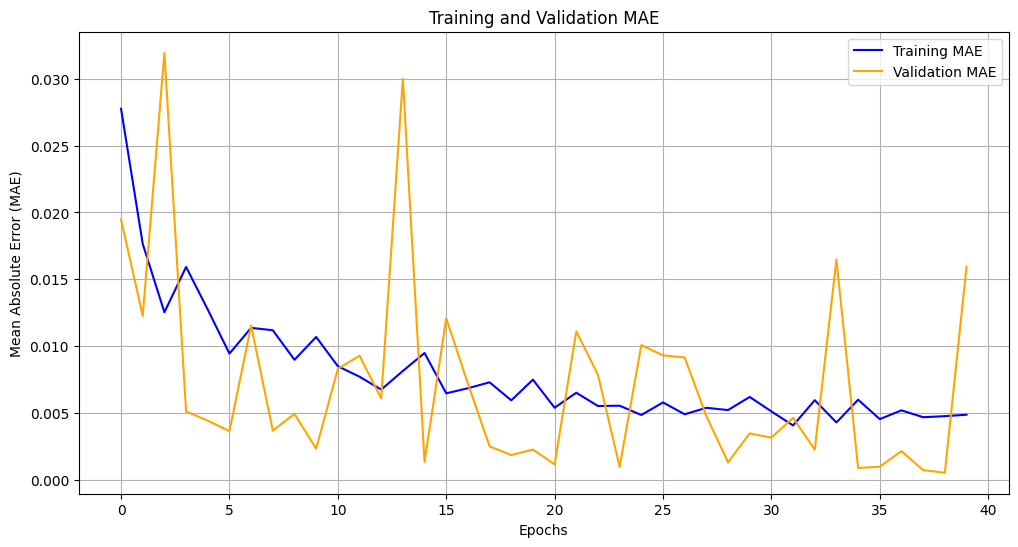

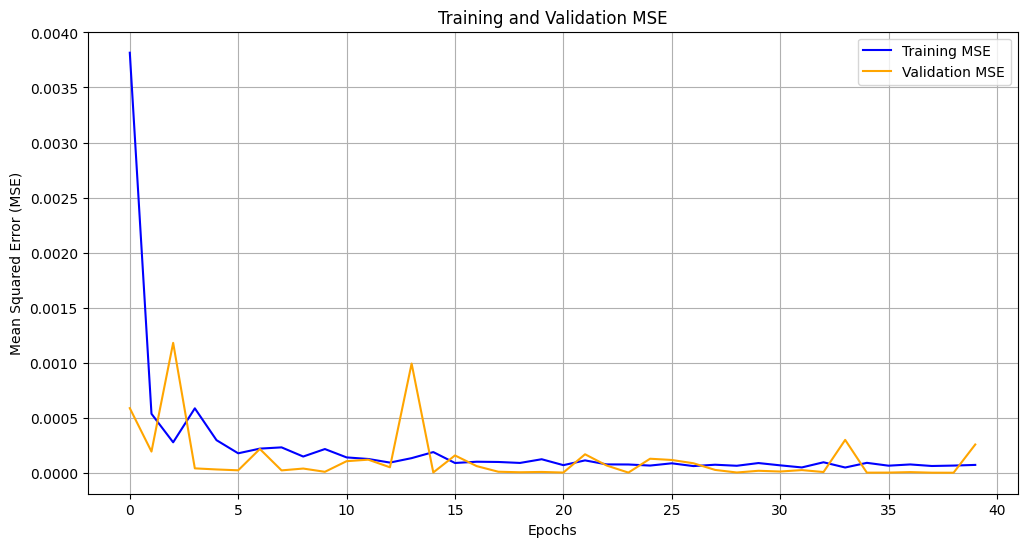

In [9]:
history = base_dnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")


### 3.5 Hyper-tuning

In [10]:
#build model
def build_model(hp):
    model = Sequential()
    num_layers_params = hp.Int('num_layers', 2, 4, step=5)

    i = 0
    unit_params = hp.Int(f'units_{i}', min_value=64, max_value=128, step=32)
    model.add(layers.Dense(units=unit_params, activation="relu", input_dim=len(features)))
    for i in range(1, num_layers_params):  
        model.add(layers.Dense(units=unit_params, activation='relu'))

    model.add(layers.Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

    return model

tuner = kt.Hyperband(build_model, objective='val_mse', factor=3, directory='nn_cache', project_name='DNN_tuning')
tuner.search(train[features],train[target],  epochs=50, validation_data=(validate[features], validate[target]), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps_dict = best_hps.values
best_hps_df = pd.DataFrame(list(best_hps_dict.items()), columns=['Hyperparameter', 'Value'])
best_hps_df

Reloading Tuner from nn_cache/DNN_tuning/tuner0.json


,Hyperparameter,Value
0,num_layers,2
1,units_0,96
2,tuner/epochs,2
3,tuner/initial_epoch,0
4,tuner/bracket,4
5,tuner/round,0


### 3.6 Evaluate hyper-tuned model 

Epoch 1/10


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1510 - mae: 0.3181 - mse: 0.1510 - val_loss: 0.0029 - val_mae: 0.0434 - val_mse: 0.0029
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102 - mae: 0.0820 - mse: 0.0102 - val_loss: 0.0013 - val_mae: 0.0304 - val_mse: 0.0013
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mae: 0.0272 - mse: 0.0013 - val_loss: 4.2969e-04 - val_mae: 0.0155 - val_mse: 4.2969e-04
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7006e-04 - mae: 0.0167 - mse: 4.7006e-04 - val_loss: 2.8845e-04 - val_mae: 0.0138 - val_mse: 2.8845e-04
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4695e-04 - mae: 0.0118 - mse: 2.4695e-04 - val_loss: 1.7204e-04 - val_mae: 0.0104 - val_mse: 1.7204e-04
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9622e-04 - mae: 0.0107 - mse: 1.9622e-04 - val_loss: 1.1488e-04 - val_mae: 0.0086 - val_mse: 1.1488e-04
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1785e-0

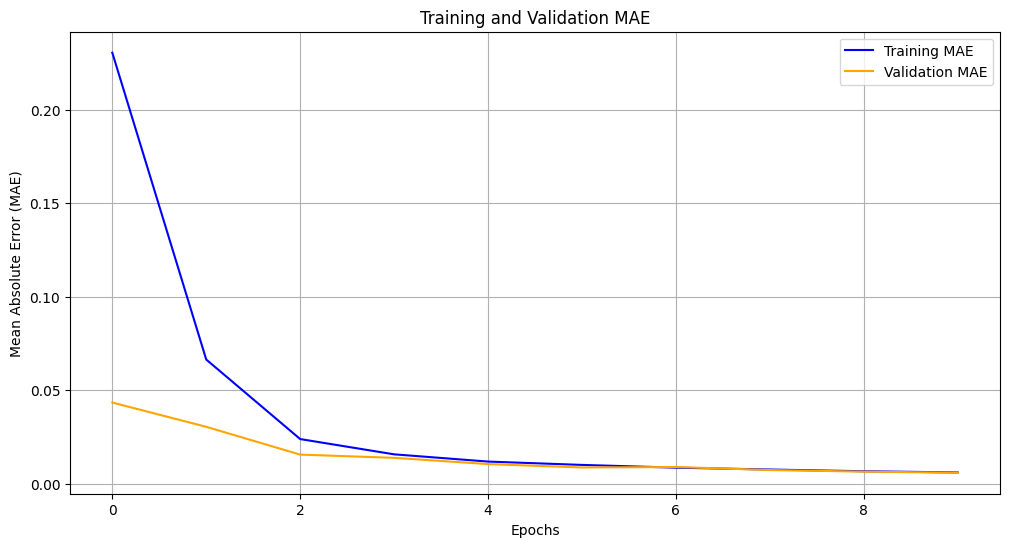

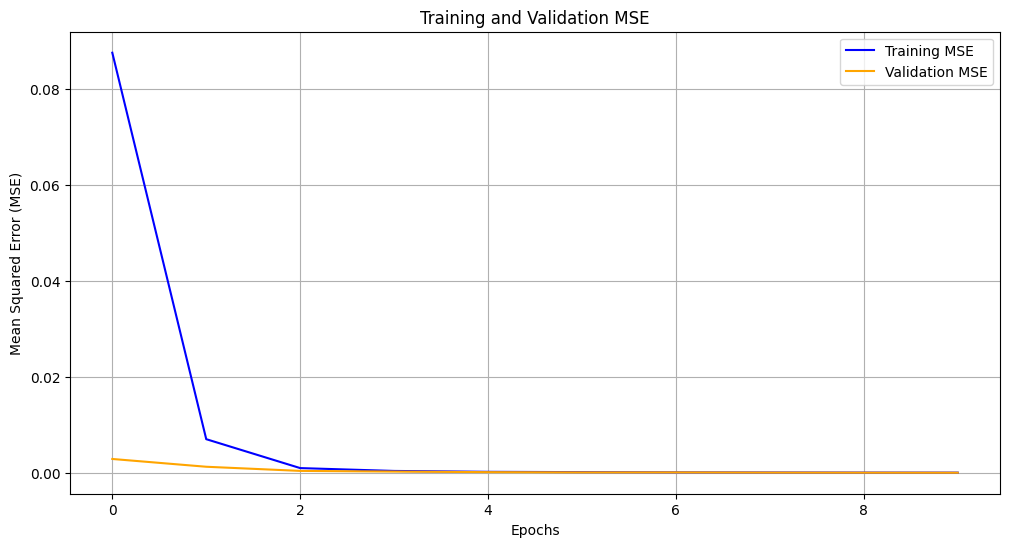

Mean Absolute Error (MAE): 0.019
Mean Squared Error (MSE): 0.001
R^2 Score: 0.886
Mean Absolute Percentage Error (MAPE): 3.287%


In [11]:

# Train the model with the best hyperparameters
dnn_model = build_model(best_hps)
history = dnn_model.fit(train[features], train[target], epochs=10, validation_data=(validate[features], validate[target]))

# Extract training and validation metrics
train_mae = history.history['mae']
train_mse = history.history['mse']
val_mae = history.history['val_mae']
val_mse = history.history['val_mse']

# Get model predictions on Test Data
y_pred = base_dnn_model.predict(test[features])
y_true = test[target]

# Plot the training and validation MAE and MSE 
plot_train_val_evaluation_history(train_mae, val_mae, "MAE")
plot_train_val_evaluation_history(train_mse, val_mse, "MSE")

# Print Evaluation Metrics
dnn_metric =  print_evaluation_metrics(y_true, y_pred)

### 3.7 Overview of whole predicted model 

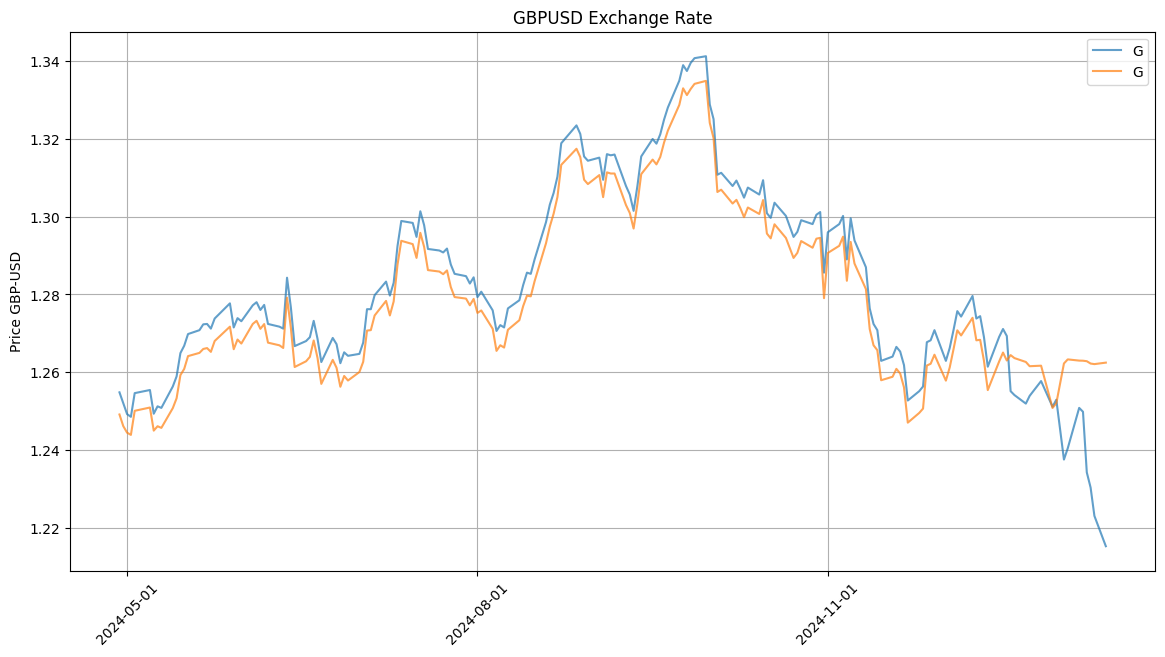

In [12]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values

actual_data = [test["Date"], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"], y_pred_unscaled, "GBPUSD Predicted"]

dnn_predicted = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 4 LSTM Neural Network (Time Series)

### 4.1 Implementing scaler on dataset

In [13]:
# Update the features as working with sequence data, its better to use previous open price as a feature
# Scaling the feature with updated scaler
features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day', 'Open']
feature_scaler = MinMaxScaler()
feature_scaler.fit(u_train[features])

# Creating a scaled dataframe
scaled_df = pd.DataFrame()

# Implementing Scaler on whole data  
scaled_df['Date'] = df['Date']
scaled_df[features] = feature_scaler.transform(df[features])
scaled_df[target] = target_scaler.transform(df[[target]])

### 4.2 Splitting & Generate Sequence

In [14]:
SEQ_LENGTH = 7

# Splitting the scaled data into train, validate, and test sets
train, validate, test = split_train_validate_test(scaled_df, train_percent=.7, validate_percent=0.15, test_percent=.15)

train_feature_seq, train_target_seq = time_sequence_generator(
    train[features].values, 
    train[target].values, 
    SEQ_LENGTH
)

validation_feature_seq, validation_target_seq = time_sequence_generator(
    validate[features].values, 
    validate[target].values, 
    SEQ_LENGTH)

test_feature_seq, test_target_seq = time_sequence_generator(
    test[features].values, 
    test[target].values, 
    SEQ_LENGTH
)

print(test_feature_seq.shape, test_target_seq.shape)

(173, 7, 7) (173,)


### 4.3 Train base model

In [15]:
lstm_base_model = Sequential([
    layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])),
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)
])

lstm_base_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

base_lstm_history = lstm_base_model.fit(test_feature_seq, test_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))

Epoch 1/50


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.4144 - mae: 0.6391 - mse: 0.4144 - val_loss: 0.2248 - val_mae: 0.4704 - val_mse: 0.2248
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2977 - mae: 0.5407 - mse: 0.2977 - val_loss: 0.1605 - val_mae: 0.3951 - val_mse: 0.1605
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2099 - mae: 0.4519 - mse: 0.2099 - val_loss: 0.0766 - val_mae: 0.2613 - val_mse: 0.0766
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0848 - mae: 0.2752 - mse: 0.0848 - val_loss: 0.0292 - val_mae: 0.1576 - val_mse: 0.0292
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0254 - mae: 0.1145 - mse: 0.0254 - val_loss: 0.0465 - val_mae: 0.1826 - val_mse: 0.0465
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0213 - mae: 0.1075 - mse: 0.0213 - val_loss: 0.0190 - val_mae: 0.1217 - val_mse: 0.0190
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - mae: 0.1128 - mse: 0.0160 - val_loss: 0.0173 - val_mae: 0.1120 

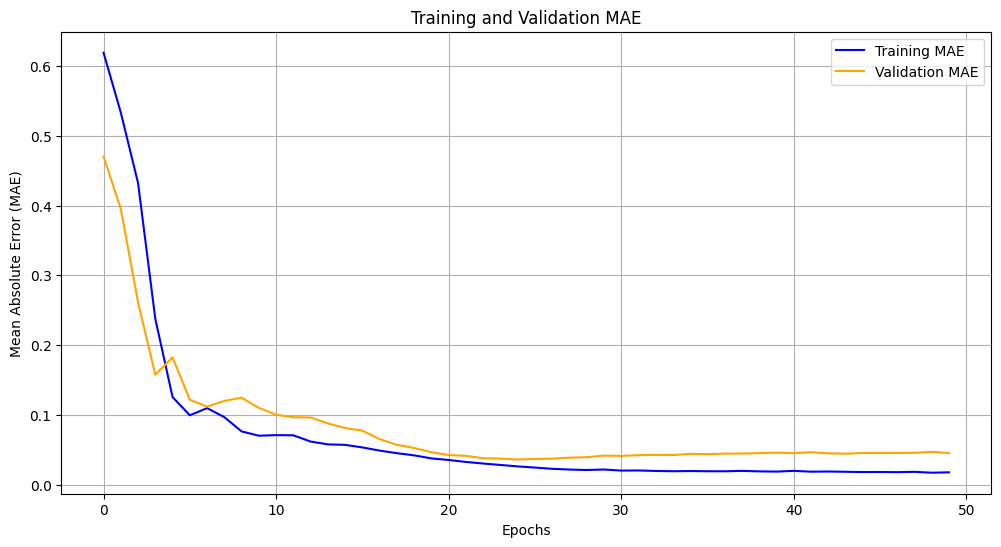

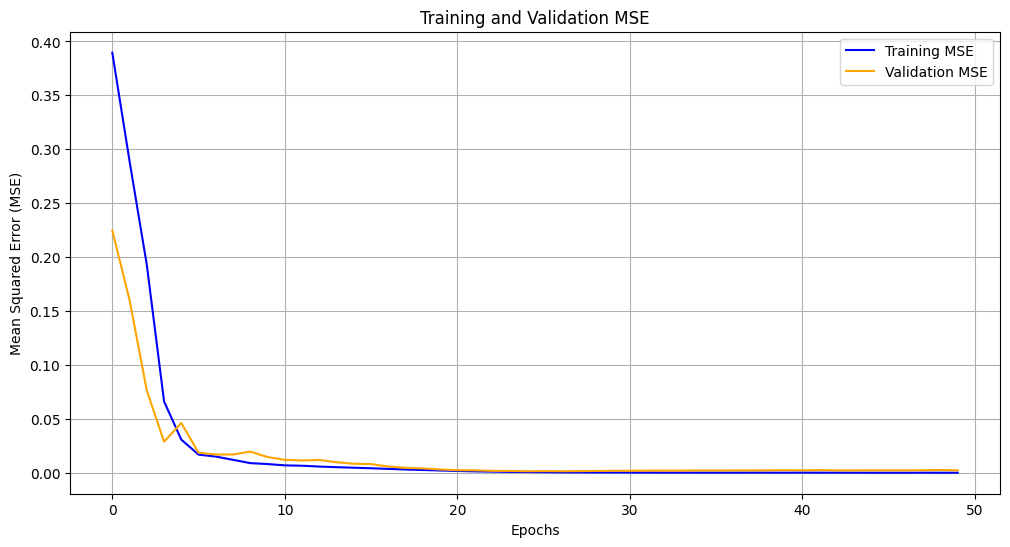

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Mean Absolute Error (MAE): 0.018
Mean Squared Error (MSE): 0.000
R^2 Score: 0.901
Mean Absolute Percentage Error (MAPE): 13.036%


In [16]:
history = base_lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
base_lstm_metric =  print_evaluation_metrics(y_true, y_pred)

### 4.4 Hyper-tune LSTM

In [17]:
import keras_tuner as kt # type: ignore

TIME_STEP = 3

def build_model(hp):
    model = keras.Sequential()


    # Adding LSTM layers
    for i in range(4):  # 3 LSTM layers
        model.add(layers.LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None,
            activation="relu",
            return_sequences=i < 3,
        ))

    # Output layer
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1))

    # Tuning learning rate

    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae', 'mse']
    )

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=25,
    factor=12,
    directory='nn_cache',
    project_name='LSTM_tuning',
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=4,
    restore_best_weights=True,
    monitor='val_mae'
)

# Hyperparameter search
tuner.search(
    train_feature_seq, train_target_seq,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(validation_feature_seq, validation_target_seq),
    batch_size=12,
    verbose=1
)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/LSTM_tuning/tuner0.json


### 4.5 Build Hyper-tuned LSTM Model

In [ ]:
lstm_model = tuner.hypermodel.build(best_hps)
lstm_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
lstm_history = lstm_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
)

Epoch 1/100


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 4.6 Evaluate the Hyper-tuned Data 

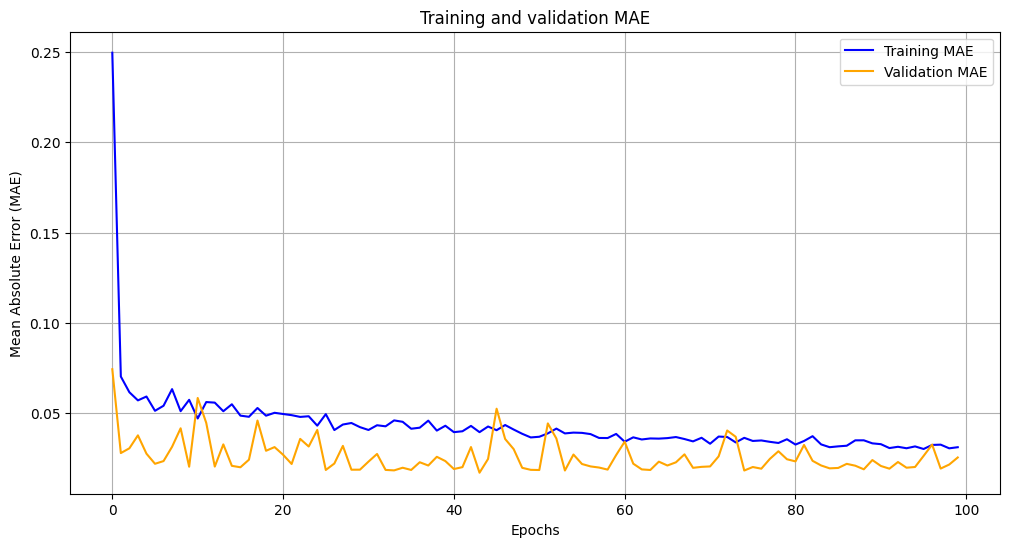

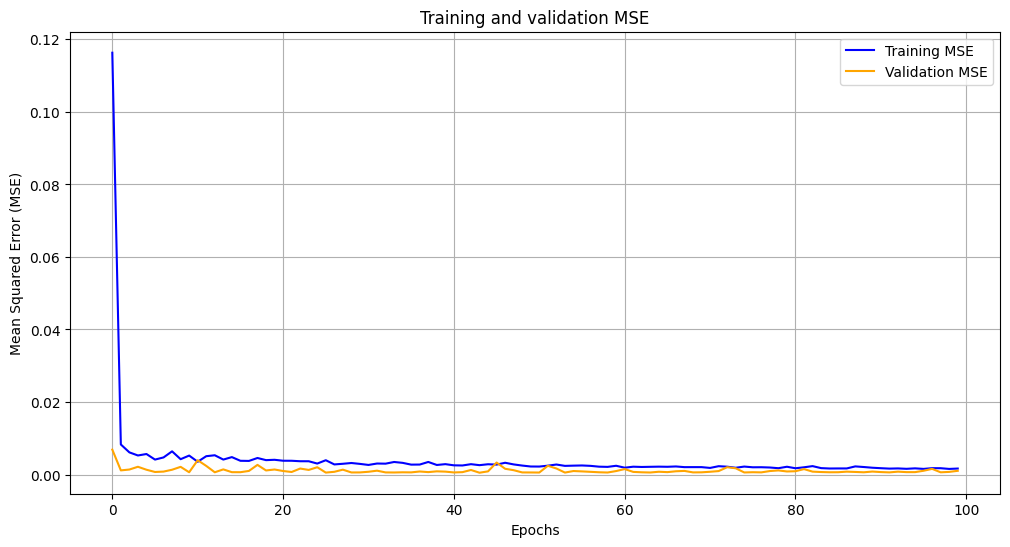

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Mean Absolute Error (MAE): 0.025
Mean Squared Error (MSE): 0.001
R^2 Score: 0.795
Mean Absolute Percentage Error (MAPE): 12.771%


In [ ]:
history = lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)


# Print Evaluation Metrics
lstm_metric =  print_evaluation_metrics(y_true, y_pred)


lstm_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

### Plot the Actual, Predicted Value 

In [ ]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values

actual_data = [test["Date"], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"], y_pred_unscaled, "GBPUSD Predicted"]

dnn_predicted = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 5. Recurrent Model

### 5.1 Build base model

In [ ]:
rnn_base_model = Sequential()
rnn_base_model.add(layers.SimpleRNN(units=64, activation='relu', input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
rnn_base_model.add(layers.Dense(1))
    
rnn_base_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

rnn_base_history = rnn_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))

Epoch 1/50


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7007 - mae: 0.6766 - mse: 0.7007 - val_loss: 0.0176 - val_mae: 0.1079 - val_mse: 0.0176
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0445 - mae: 0.1736 - mse: 0.0445 - val_loss: 0.0060 - val_mae: 0.0621 - val_mse: 0.0060
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 - mae: 0.0765 - mse: 0.0090 - val_loss: 0.0033 - val_mae: 0.0458 - val_mse: 0.0033
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - mae: 0.0474 - mse: 0.0035 - val_loss: 0.0018 - val_mae: 0.0341 - val_mse: 0.0018
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - mae: 0.0381 - mse: 0.0024 - val_loss: 0.0017 - val_mae: 0.0321 - val_mse: 0.0017
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - mae: 0.0312 - mse: 0.0017 - val_loss: 0.0022 - val_mae: 0.0385 - val_mse: 0.0022
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - mae: 0.0351 - mse: 0.0019 - val_loss: 0.0017 - val_mae: 

### 5.2 Evaluate base model 

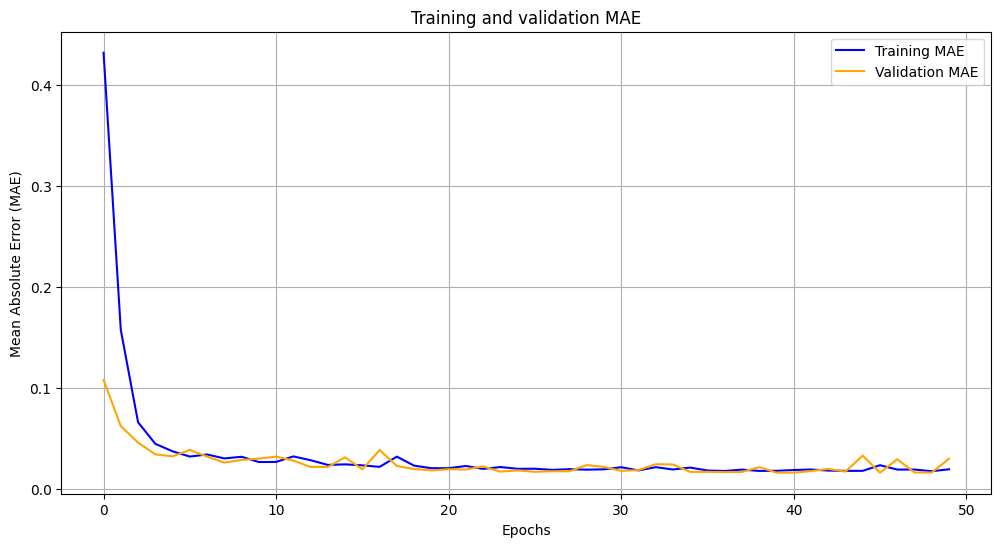

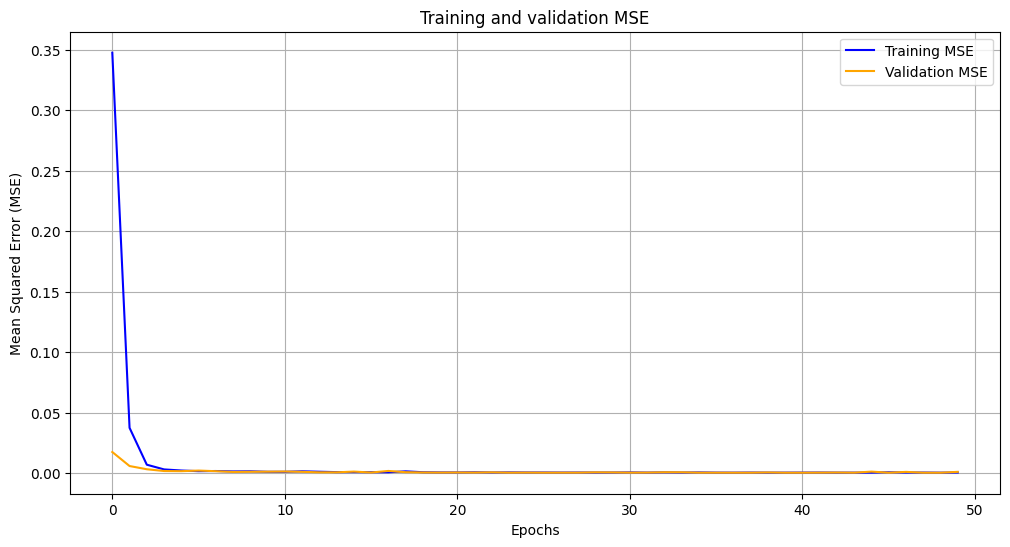

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Mean Absolute Error (MAE): 0.033
Mean Squared Error (MSE): 0.002
R^2 Score: 0.607
Mean Absolute Percentage Error (MAPE): 13.642%


In [ ]:
history = rnn_base_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_base_metric = print_evaluation_metrics(y_true, y_pred)

### 5.3 Hyper-tune RNN model

In [ ]:
# Build RNN model
def build_model(hp):
	model = Sequential()
	num_layers = hp.Int('num_layers', min_value=1, max_value=4)
	for i in range(num_layers):
		model.add(layers.SimpleRNN(
			units=hp.Int(f'units_{i}', min_value=16, max_value=62, step=16),
			activation='relu',
			return_sequences=(i != num_layers - 1),
			input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None
		))
		model.add(layers.Dropout(0.1))
	
	model.add(layers.Dense(units=1))  # Output layer

	model.compile(
		optimizer=tf.keras.optimizers.Adam(
			learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
		),
		loss='mean_squared_error',
		metrics=['mae', 'mse']
	)
	return model

# Hyperband tuner
tuner = kt.Hyperband(
	build_model,
	objective='val_loss',
	max_epochs=25,
	factor=3,
	directory='nn_cache',
	project_name='RNN'
)

# Search for the best hyperparameters
tuner.search(train_feature_seq, train_target_seq, epochs=50, validation_data=(validation_feature_seq, validation_target_seq), batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

Reloading Tuner from nn_cache/RNN/tuner0.json


{'num_layers': 1,
 'units_0': 32,
 'learning_rate': 0.00104935888624918,
 'units_1': 16,
 'units_2': 48,
 'units_3': 48,
 'tuner/epochs': 25,
 'tuner/initial_epoch': 9,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0021'}

### 5.4 Build Hyper-tune model 

In [ ]:
rnn_model = tuner.hypermodel.build(best_hps)
rnn_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
rnn_history = rnn_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=50,
    validation_data=(validation_feature_seq, validation_target_seq),
)

Epoch 1/100


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9522 - mae: 1.9522 - mse: 4.3370 - val_loss: 0.6300 - val_mae: 0.6300 - val_mse: 0.4636
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7272 - mae: 0.7272 - mse: 0.7452 - val_loss: 0.3512 - val_mae: 0.3512 - val_mse: 0.1602
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3452 - mae: 0.3452 - mse: 0.1938 - val_loss: 0.0879 - val_mae: 0.0879 - val_mse: 0.0120
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2443 - mae: 0.2443 - mse: 0.0899 - val_loss: 0.0959 - val_mae: 0.0959 - val_mse: 0.0139
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1841 - mae: 0.1841 - mse: 0.0577 - val_loss: 0.0744 - val_mae: 0.0744 - val_mse: 0.0084
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1474 - mae: 0.1474 - mse: 0.0363 - val_loss: 0.0718 - val_mae: 0.0718 - val_mse: 0.0076
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1269 - mae: 0.1269 - mse: 0.0281 - val_loss: 0.0684 - val

### 5.4 Evaluate Hyper-tuned model

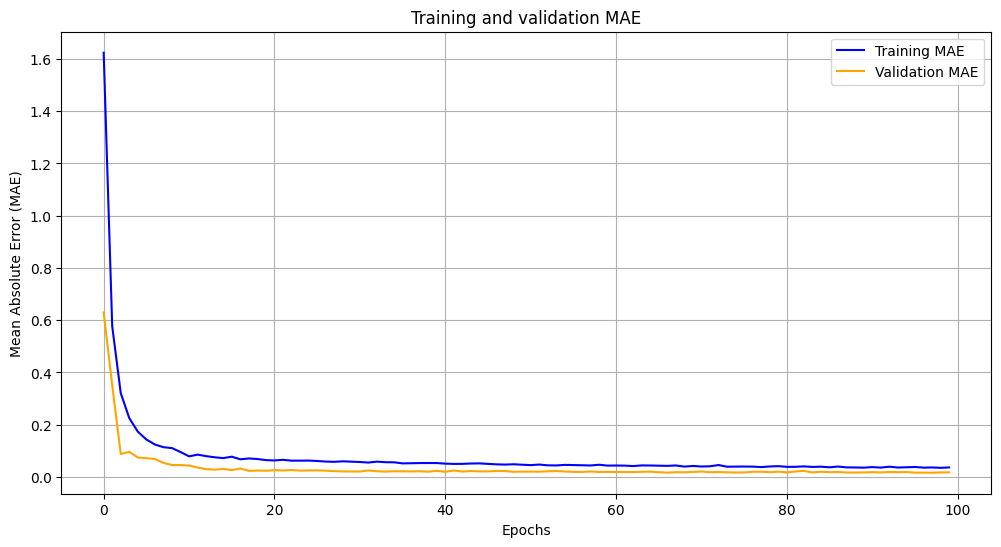

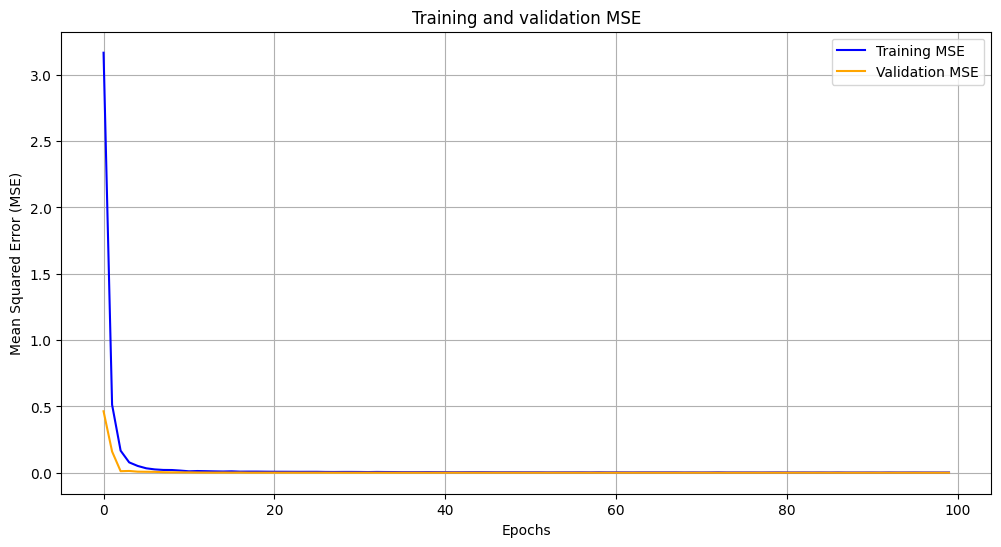

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Mean Absolute Error (MAE): 0.017
Mean Squared Error (MSE): 0.001
R^2 Score: 0.874
Mean Absolute Percentage Error (MAPE): 12.624%


In [ ]:
history = rnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_metric =  print_evaluation_metrics(y_true, y_pred)


rnn_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

# 6. CNN_LSTM Model

### 6.1 Develop Base Model

In [ ]:
cl_base_model = keras.Sequential()

cl_base_model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
cl_base_model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cl_base_model.add(layers.LSTM(units=64, return_sequences=False))
cl_base_model.add(layers.Dense(units=1, activation='linear'))
cl_base_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

cl_base_history = cl_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2494 - mae: 0.4249 - mse: 0.2494 - val_loss: 0.0079 - val_mae: 0.0738 - val_mse: 0.0079
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - mae: 0.1188 - mse: 0.0227 - val_loss: 0.0055 - val_mae: 0.0596 - val_mse: 0.0055
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - mae: 0.0506 - mse: 0.0041 - val_loss: 0.0010 - val_mae: 0.0263 - val_mse: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0306 - mse: 0.0016 - val_loss: 8.0384e-04 - val_mae: 0.0232 - val_mse: 8.0384e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - mae: 0.0346 - mse: 0.0019 - val_loss: 9.3960e-04 - val_mae: 0.0241 - val_mse: 9.3960e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - mae: 0.0321 - mse: 0.0017 - val_loss: 6.3681e-04 - val_mae: 0.0194 - val_mse: 6.3681e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mae: 0.0273 - mse: 0.

### 6.2 Evaluate Base Model

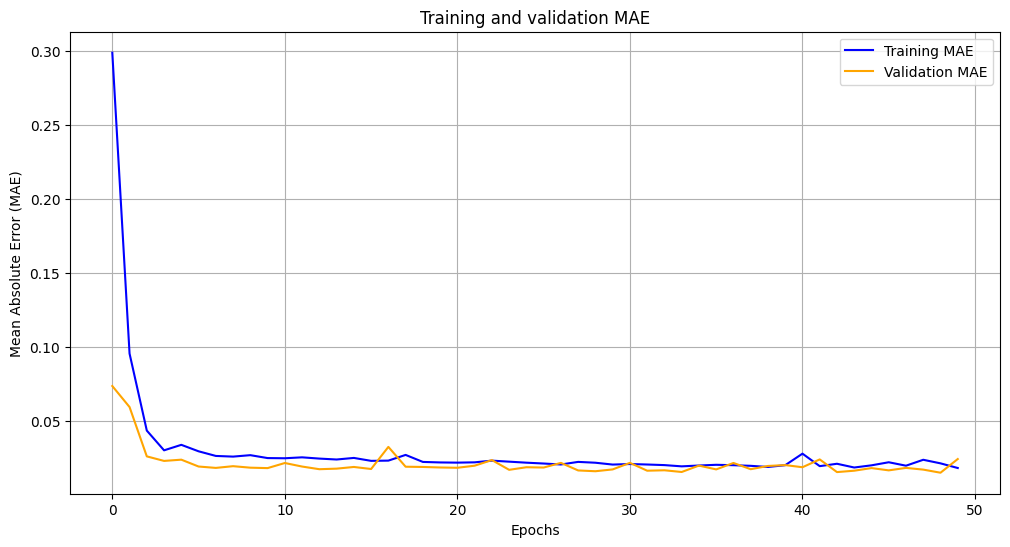

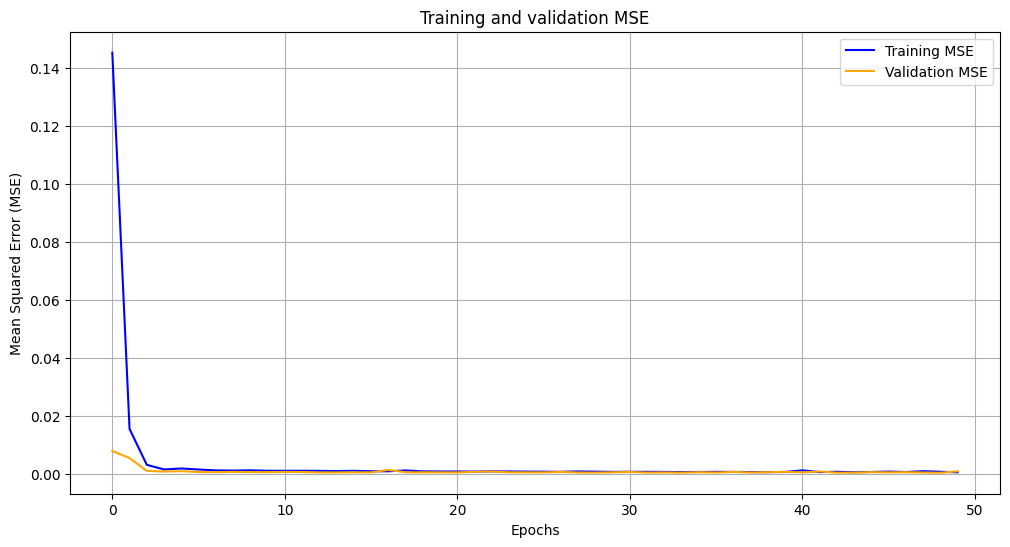

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Absolute Error (MAE): 0.033
Mean Squared Error (MSE): 0.002
R^2 Score: 0.607
Mean Absolute Percentage Error (MAPE): 13.642%


In [ ]:
history = cl_base_history.history
train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
cl_base_metric =  print_evaluation_metrics(y_true, y_pred)

### 6.3 Hyper-tune model

In [ ]:
# Define LSTM-CNN Model with hyper-tuning for the number of layers
def build_lstm_cnn_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
    
    for i in range(hp.Int('num_cnn_layers', 1, 2)):
        model.add(layers.Conv1D(
            filters=hp.Int(f'cnn_filters_{i}', min_value=50, max_value=100, step=25),
            kernel_size=hp.Choice(f'cnn_kernel_size_{i}', values=[1, 2]),
            activation='relu'
        ))
    
    # Hyper-tuning number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 2)):
        model.add(layers.LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=64, step=8),
            return_sequences=True if i < hp.get('num_lstm_layers') - 1 else False
        ))
        model.add(layers.Dropout(hp.Float('dropout_rate', 0.1, 0.2, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

print(train_target_seq)
# Hyperband tuner
tuner = kt.Hyperband(
    build_lstm_cnn_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='nn_cache',
    project_name='lstm_cnn'
)

# Run Hyperband tuning
tuner.search(train_feature_seq, train_target_seq, validation_data=(validation_feature_seq, validation_target_seq), epochs=50, batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

[0.45701096 0.47345643 0.45960762 0.48009233 0.48788229 0.48788229
 0.5389498  0.51990767 0.48355453 0.49307559 0.46653203 0.44489325
 0.46537796 0.45729948 0.42729371 0.41950375 0.39844201 0.41748413
 0.43450664 0.43998846 0.42325447 0.4169071  0.46682054 0.42469706
 0.45527986 0.46826313 0.50086555 0.52279284 0.53433353 0.5372187
 0.5712637  0.56347374 0.57039815 0.57991922 0.54818234 0.51759954
 0.52336988 0.53029429 0.51933064 0.48326601 0.46624351 0.49134449
 0.51211771 0.49192152 0.47922677 0.45441431 0.43941143 0.46566647
 0.49422966 0.4965378  0.49711483 0.50894403 0.52798615 0.53404501
 0.53952683 0.55308713 0.5406809  0.51500289 0.54183497 0.53433353
 0.51673399 0.54875938 0.57818811 0.57328332 0.57732256 0.58972879
 0.6203116  0.63531448 0.64079631 0.66387767 0.68695903 0.65983843
 0.67339873 0.69186382 0.69186382 0.66532025 0.6762839  0.67570687
 0.66733987 0.67830352 0.68234276 0.67916907 0.71494518 0.70311598
 0.69215234 0.67166763 0.67109059 0.68465089 0.70628967 0.70513

In [ ]:
lc_model = tuner.hypermodel.build(best_hps)
lc_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
lc_history = lc_model.fit(
    train_feature_seq, train_target_seq,
    epochs=200,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2114 - mae: 0.2114 - mse: 0.0882 - val_loss: 0.0315 - val_mae: 0.0315 - val_mse: 0.0016
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0573 - mae: 0.0573 - mse: 0.0055 - val_loss: 0.0226 - val_mae: 0.0226 - val_mse: 7.9652e-04
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0515 - mae: 0.0515 - mse: 0.0042 - val_loss: 0.0324 - val_mae: 0.0324 - val_mse: 0.0015
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0528 - mae: 0.0528 - mse: 0.0046 - val_loss: 0.0483 - val_mae: 0.0483 - val_mse: 0.0029
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0540 - mae: 0.0540 - mse: 0.0046 - val_loss: 0.0259 - val_mae: 0.0259 - val_mse: 8.9188e-04
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488 - mae: 0.0488 - mse: 0.0039 - val_loss: 0.0224 - val_mae: 0.0224 - val_mse: 7.7555e-04
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0510 - mae: 0.0510 - mse: 0.0043 

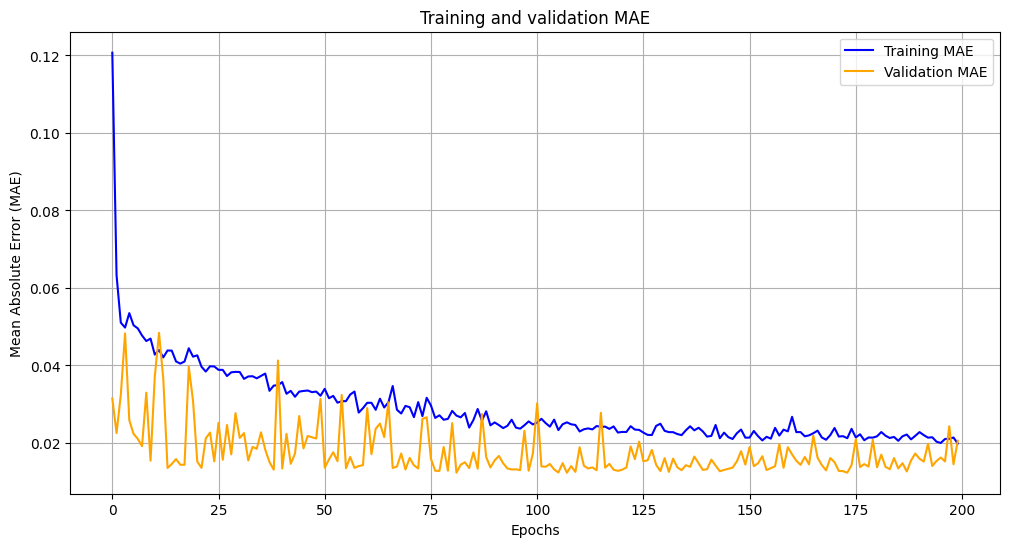

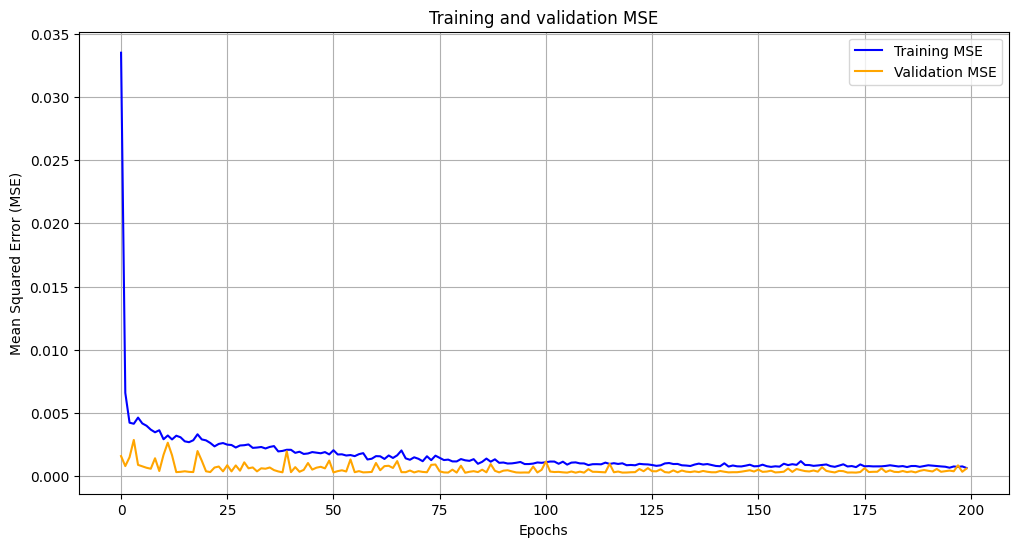

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Mean Absolute Error (MAE): 0.022
Mean Squared Error (MSE): 0.001
R^2 Score: 0.799
Mean Absolute Percentage Error (MAPE): 12.767%


In [ ]:
def evaluate_model(history, model, test_features, test_target):
	# Extract training and validation metrics
	train_mae, train_mse = history['mae'], history['mse']
	validate_mae, validate_mse = history['val_mae'], history['val_mse']

	# Plot the training and validation MAE and MSE
	plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
	plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

	# Get model predictions on Test Data
	y_pred = model.predict(test_features)
	y_true = pd.DataFrame(test_target)

	# Print Evaluation Metrics
	metric  = print_evaluation_metrics(y_true, y_pred)

	return metric, y_pred

lc_metric, y_pred =  evaluate_model(lc_history.history, lc_model, test_feature_seq, test_target_seq)
lc_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))


# Plot all metrics in a single table

In [ ]:
metrics = [dnn_metric, lstm_metric, rnn_metric, lc_metric]  

df = pd.DataFrame()
# Initialize the DataFrame with appropriate columns
df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R Square', 'MAPE'])

# Populate the DataFrame with metrics
for i, m in enumerate(metrics):
	df = pd.concat([df, pd.DataFrame([{
		'Model': f'Model {i + 1}',
		'MAE': m['MAE'],
		'MSE': m['MSE'],
		'R Square': m['R Square'],
		'MAPE': m['MAPE']
	}])], ignore_index=True)

df
        

/var/folders/xz/1gn0m18n5k1bjmbt205k50cm0000gn/T/ipykernel_8339/999570319.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


,Model,MAE,MSE,R Square,MAPE
0,Model 1,0.010141,0.000598,0.880323,1.979132
1,Model 2,0.025422,0.000997,0.794715,12.771067
2,Model 3,0.017195,0.000610,0.874449,12.623842
3,Model 4,0.022246,0.000979,0.798553,12.766761


IndexError: list index out of range

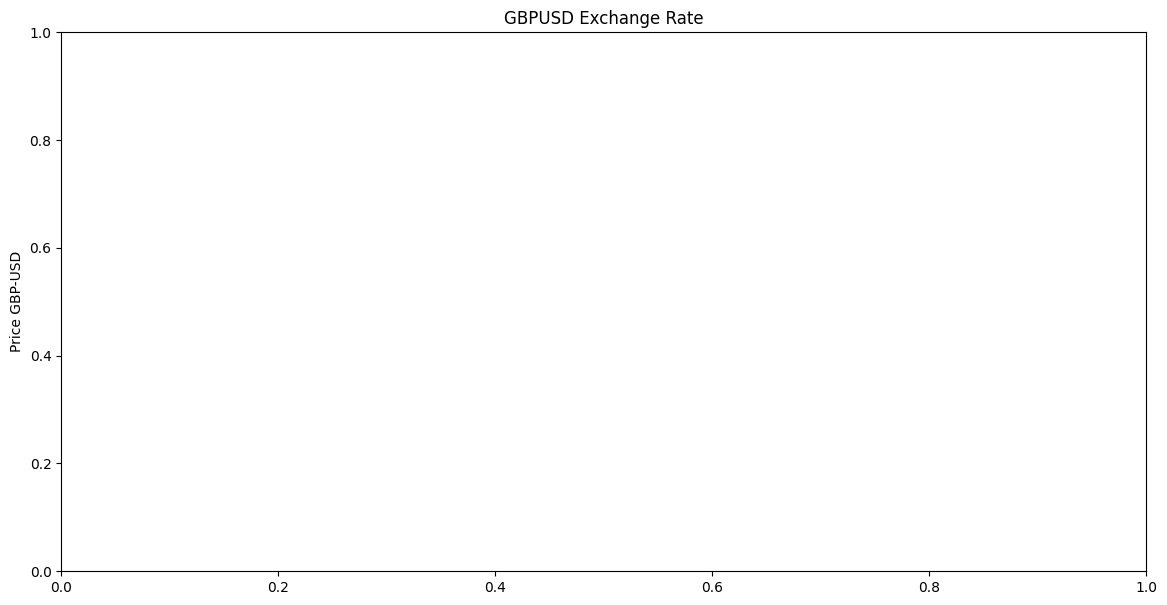

In [ ]:
dnn_features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day', 'Open']

plot_gbp_usd([
	[test['Date'], u_test['Open']], "GBPUSD Actual",
	[test['Date'], dnn_predicted], "GPBUSD DNN Predicted",
	[test['Date'][7:], lstm_pred.flatten(), "GBPUSD LSTM Predicted"],
	[test['Date'][7:], rnn_pred.flatten(), "GBPUSD RNN Predicted"],
	[test['Date'][7:], lc_pred.flatten(), "GBPUSD LSTM-CNN Predicted"],
])